# EfficientDet - 과일 종류 분류 (사과/배/감)
## 목표: cate1 기반 3-class Object Detection

**Classes:**
- 0: 사과
- 1: 배
- 2: 감

In [9]:
# 1. 환경 설정 및 라이브러리 임포트
import os
import json
import glob
import torch
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

# 경로 설정
BASE_DIR = os.path.abspath('..')
DATASET_DIR = os.path.join(BASE_DIR, 'datasets')
IMAGES_DIR = os.path.join(DATASET_DIR, 'images')
LABELS_DIR = os.path.join(DATASET_DIR, 'json_labels')
OUTPUT_DIR = os.path.join(BASE_DIR, 'efficientdet', 'outputs')
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Base Directory: {BASE_DIR}")
print(f"Dataset Directory: {DATASET_DIR}")
print(f"Images Directory: {IMAGES_DIR}")
print(f"Labels Directory: {LABELS_DIR}")

PyTorch version: 2.5.1
CUDA available: False
Base Directory: c:\Github\class\z-mini_project\fruits
Dataset Directory: c:\Github\class\z-mini_project\fruits\datasets
Images Directory: c:\Github\class\z-mini_project\fruits\datasets\images
Labels Directory: c:\Github\class\z-mini_project\fruits\datasets\json_labels


In [10]:
# 2. 데이터셋 분석 및 통계
def analyze_dataset():
    """데이터셋 구조 분석"""
    json_files = glob.glob(os.path.join(LABELS_DIR, '*.json'))
    
    class_counts = {'사과': 0, '배': 0, '감': 0}
    total_boxes = 0
    
    print(f"\n총 JSON 파일 수: {len(json_files)}")
    
    for json_file in json_files[:5]:  # 샘플 5개 출력
        with open(json_file, 'r', encoding='utf-8') as f:
            data = json.load(f)
            print(f"\n파일: {os.path.basename(json_file)}")
            print(f"  cate1: {data.get('cate1', 'N/A')}")
            print(f"  cate3: {data.get('cate3', 'N/A')}")
            print(f"  bndbox: {data.get('bndbox', {})}")
    
    # 전체 통계
    for json_file in json_files:
        with open(json_file, 'r', encoding='utf-8') as f:
            data = json.load(f)
            cate1 = data.get('cate1', '')
            if cate1 in class_counts:
                class_counts[cate1] += 1
                total_boxes += 1
    
    print(f"\n=== 데이터셋 통계 ===")
    print(f"총 이미지 수: {len(json_files)}")
    print(f"총 객체 수: {total_boxes}")
    for cls, count in class_counts.items():
        print(f"  {cls}: {count}개 ({count/total_boxes*100:.1f}%)")
    
    return class_counts

stats = analyze_dataset()


총 JSON 파일 수: 70

파일: apple_fuji_L_26-53.json
  cate1: 사과
  cate3: 특
  bndbox: {'xmin': 0, 'ymin': 0, 'xmax': 1000, 'ymax': 1000}

파일: apple_fuji_L_26-54.json
  cate1: 사과
  cate3: 특
  bndbox: {'xmin': 0, 'ymin': 0, 'xmax': 1000, 'ymax': 1000}

파일: apple_fuji_L_26-55.json
  cate1: 사과
  cate3: 특
  bndbox: {'xmin': 0, 'ymin': 0, 'xmax': 1000, 'ymax': 1000}

파일: apple_fuji_L_26-56.json
  cate1: 사과
  cate3: 특
  bndbox: {'xmin': 0, 'ymin': 0, 'xmax': 1000, 'ymax': 1000}

파일: apple_fuji_L_26-57.json
  cate1: 사과
  cate3: 특
  bndbox: {'xmin': 0, 'ymin': 0, 'xmax': 1000, 'ymax': 1000}

=== 데이터셋 통계 ===
총 이미지 수: 70
총 객체 수: 70
  사과: 30개 (42.9%)
  배: 10개 (14.3%)
  감: 30개 (42.9%)


In [11]:
# 3. COCO 형식 데이터셋 변환
class FruitDatasetConverter:
    """JSON to COCO format converter for cate1 (fruit type)"""
    
    def __init__(self, images_dir, labels_dir, output_dir):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.output_dir = output_dir
        
        # cate1 기반 클래스 매핑
        self.class_map = {
            '사과': 0,
            '배': 1,
            '감': 2
        }
        self.classes = ['사과', '배', '감']
        
    def convert_to_coco(self, split_ratio=0.8):
        """COCO 형식으로 변환 및 train/val 분할"""
        
        json_files = sorted(glob.glob(os.path.join(self.labels_dir, '*.json')))
        np.random.seed(42)
        np.random.shuffle(json_files)
        
        split_idx = int(len(json_files) * split_ratio)
        train_files = json_files[:split_idx]
        val_files = json_files[split_idx:]
        
        print(f"\n데이터 분할:")
        print(f"  Train: {len(train_files)}개")
        print(f"  Val: {len(val_files)}개")
        
        # Train/Val 각각 변환
        train_coco = self._create_coco_dataset(train_files, 'train')
        val_coco = self._create_coco_dataset(val_files, 'val')
        
        # 저장
        train_json_path = os.path.join(self.output_dir, 'train_cate1.json')
        val_json_path = os.path.join(self.output_dir, 'val_cate1.json')
        
        with open(train_json_path, 'w', encoding='utf-8') as f:
            json.dump(train_coco, f, ensure_ascii=False, indent=2)
        
        with open(val_json_path, 'w', encoding='utf-8') as f:
            json.dump(val_coco, f, ensure_ascii=False, indent=2)
        
        print(f"\n✅ COCO 파일 생성 완료:")
        print(f"  Train: {train_json_path}")
        print(f"  Val: {val_json_path}")
        
        return train_json_path, val_json_path
    
    def _create_coco_dataset(self, json_files, split_name):
        """COCO 데이터셋 구조 생성"""
        
        coco_dataset = {
            "images": [],
            "annotations": [],
            "categories": []
        }
        
        # Categories 추가
        for idx, class_name in enumerate(self.classes):
            coco_dataset["categories"].append({
                "id": idx,
                "name": class_name,
                "supercategory": "fruit"
            })
        
        annotation_id = 0
        
        for image_id, json_file in enumerate(tqdm(json_files, desc=f"Converting {split_name}")):
            with open(json_file, 'r', encoding='utf-8') as f:
                data = json.load(f)
            
            # 이미지 파일명
            img_filename = os.path.basename(json_file).replace('.json', '.png')
            img_path = os.path.join(self.images_dir, img_filename)
            
            if not os.path.exists(img_path):
                continue
            
            # 이미지 정보
            img = Image.open(img_path)
            width, height = img.size
            
            coco_dataset["images"].append({
                "id": image_id,
                "file_name": img_filename,
                "width": width,
                "height": height
            })
            
            # Annotation 추가
            cate1 = data.get('cate1', '')
            if cate1 not in self.class_map:
                continue
            
            bbox = data.get('bndbox', {})
            xmin = float(bbox.get('xmin', 0))
            ymin = float(bbox.get('ymin', 0))
            xmax = float(bbox.get('xmax', width))
            ymax = float(bbox.get('ymax', height))
            
            bbox_width = xmax - xmin
            bbox_height = ymax - ymin
            area = bbox_width * bbox_height
            
            coco_dataset["annotations"].append({
                "id": annotation_id,
                "image_id": image_id,
                "category_id": self.class_map[cate1],
                "bbox": [xmin, ymin, bbox_width, bbox_height],  # COCO format: [x, y, w, h]
                "area": area,
                "iscrowd": 0
            })
            
            annotation_id += 1
        
        print(f"{split_name} - Images: {len(coco_dataset['images'])}, Annotations: {len(coco_dataset['annotations'])}")
        
        return coco_dataset

# 데이터셋 변환 실행
converter = FruitDatasetConverter(IMAGES_DIR, LABELS_DIR, OUTPUT_DIR)
train_json, val_json = converter.convert_to_coco(split_ratio=0.8)


데이터 분할:
  Train: 56개
  Val: 14개


Converting train:   0%|          | 0/56 [00:00<?, ?it/s]

Converting train: 100%|██████████| 56/56 [00:00<00:00, 352.70it/s]


train - Images: 56, Annotations: 56


Converting val: 100%|██████████| 14/14 [00:00<00:00, 873.03it/s]

val - Images: 14, Annotations: 14

✅ COCO 파일 생성 완료:
  Train: c:\Github\class\z-mini_project\fruits\efficientdet\outputs\train_cate1.json
  Val: c:\Github\class\z-mini_project\fruits\efficientdet\outputs\val_cate1.json


In [12]:
# 4. PyTorch Dataset 클래스
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class COCOFruitDataset(Dataset):
    """COCO 형식 과일 데이터셋"""
    
    def __init__(self, images_dir, coco_json_path, transform=None):
        self.images_dir = images_dir
        self.transform = transform
        
        with open(coco_json_path, 'r') as f:
            self.coco_data = json.load(f)
        
        self.images = self.coco_data['images']
        self.annotations = self.coco_data['annotations']
        
        # image_id를 키로 하는 annotations 딕셔너리 생성
        self.img_to_anns = {}
        for ann in self.annotations:
            img_id = ann['image_id']
            if img_id not in self.img_to_anns:
                self.img_to_anns[img_id] = []
            self.img_to_anns[img_id].append(ann)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_info = self.images[idx]
        img_path = os.path.join(self.images_dir, img_info['file_name'])
        
        # 이미지 로드
        image = Image.open(img_path).convert('RGB')
        image = np.array(image)
        
        # Annotations 가져오기
        img_id = img_info['id']
        anns = self.img_to_anns.get(img_id, [])
        
        boxes = []
        labels = []
        
        for ann in anns:
            x, y, w, h = ann['bbox']
            boxes.append([x, y, x + w, y + h])  # [xmin, ymin, xmax, ymax]
            labels.append(ann['category_id'])
        
        boxes = np.array(boxes, dtype=np.float32)
        labels = np.array(labels, dtype=np.int64)
        
        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': img_id
        }
        
        if self.transform:
            image = self.transform(image)
        
        return image, target

# Transform 정의
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 데이터셋 및 DataLoader 생성
train_dataset = COCOFruitDataset(IMAGES_DIR, train_json, transform=transform)
val_dataset = COCOFruitDataset(IMAGES_DIR, val_json, transform=transform)

print(f"\n✅ 데이터셋 로드 완료:")
print(f"  Train 샘플 수: {len(train_dataset)}")
print(f"  Val 샘플 수: {len(val_dataset)}")

# 샘플 데이터 확인
sample_img, sample_target = train_dataset[0]
print(f"\n샘플 데이터:")
print(f"  Image shape: {sample_img.shape}")
print(f"  Boxes: {sample_target['boxes']}")
print(f"  Labels: {sample_target['labels']}")


✅ 데이터셋 로드 완료:
  Train 샘플 수: 56
  Val 샘플 수: 14

샘플 데이터:
  Image shape: torch.Size([3, 512, 512])
  Boxes: [[   0.    0. 1000. 1000.]]
  Labels: [0]


In [13]:
# 5. EfficientDet 모델 로드 (effdet 라이브러리 사용)
# effdet 설치: !pip install effdet

try:
    from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain
    from effdet.efficientdet import HeadNet
except ImportError:
    print("⚠️  effdet 라이브러리가 설치되지 않았습니다.")
    print("다음 명령어로 설치하세요:")
    print("!pip install effdet")
    print("또는 conda 환경에서:")
    print("pip install effdet")

# EfficientDet-D1 설정
def create_model(num_classes=3):
    """EfficientDet-D1 모델 생성"""
    
    config = get_efficientdet_config('tf_efficientdet_d1')
    config.num_classes = num_classes
    config.image_size = (512, 512)
    
    net = EfficientDet(config, pretrained_backbone=True)
    net.class_net = HeadNet(
        config,
        num_outputs=config.num_classes,
    )
    
    model = DetBenchTrain(net, config)
    
    return model, config

model, config = create_model(num_classes=3)
device = torch.device('cpu')
model = model.to(device)

print(f"\n✅ EfficientDet-D1 모델 로드 완료")
print(f"  Device: {device}")
print(f"  Input size: {config.image_size}")
print(f"  Classes: {config.num_classes}")


✅ EfficientDet-D1 모델 로드 완료
  Device: cpu
  Input size: [512, 512]
  Classes: 3


In [14]:
# 6. 학습 함수 정의
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR

def collate_fn(batch):
    """배치 데이터 collate 함수"""
    images = []
    targets = []
    
    for img, target in batch:
        images.append(img)
        targets.append(target)
    
    images = torch.stack(images, dim=0)
    
    return images, targets

def train_one_epoch(model, dataloader, optimizer, device, epoch):
    """1 에폭 학습"""
    model.train()
    
    total_loss = 0
    num_batches = 0  # 이 줄 추가
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}")
    
    for images, targets in progress_bar:
        images = images.to(device)
        
        # EfficientDet은 targets를 특별한 형식으로 받음
        batch_size = images.size(0)
        
        # targets를 모델이 요구하는 형식으로 변환
        target_dict = {
            'bbox': [],
            'cls': []
        }
        
        for target in targets:
            boxes = torch.tensor(target['boxes'], dtype=torch.float32)
            labels = torch.tensor(target['labels'], dtype=torch.int64)
            
            target_dict['bbox'].append(boxes)
            target_dict['cls'].append(labels)
        
        # Forward
        optimizer.zero_grad()
        
        try:
            output = model(images, target_dict)
            
            # output이 튜플인 경우 첫 번째 요소가 loss
            if isinstance(output, tuple):
                loss = output[0]
            else:
                loss = output
            
            # loss가 dict인 경우
            if isinstance(loss, dict):
                loss = sum(loss.values())
            
            # loss가 텐서인지 확인
            if isinstance(loss, torch.Tensor):
                if loss.dim() > 0:
                    loss = loss.mean()
            else:
                print(f"\n⚠️  예상치 못한 loss 타입: {type(loss)}")
                continue
            
            # Backward
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            num_batches += 1
            progress_bar.set_postfix({'loss': loss.item()})

        except Exception as e:
            print(f"\n⚠️  배치 처리 중 에러 발생: {e}")
            import traceback
            traceback.print_exc()
            continue
    
    avg_loss = total_loss / max(num_batches, 1)
    return avg_loss

# DataLoader 생성
train_loader = DataLoader(
    train_dataset,
    batch_size=4,  # CPU에서는 작은 배치 사용
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=0
)

val_loader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=0
)

print(f"\n✅ DataLoader 생성 완료")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")


✅ DataLoader 생성 완료
  Train batches: 14
  Val batches: 4


In [15]:
# 7. 학습 실행
NUM_EPOCHS = 1
LEARNING_RATE = 1e-4

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=1e-6)

print(f"\n🚀 학습 시작...")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"  Optimizer: AdamW")
print(f"  Scheduler: CosineAnnealingLR")
print(f"\n{'='*60}\n")

train_losses = []
best_loss = float('inf')

for epoch in range(NUM_EPOCHS):
    # 학습
    train_loss = train_one_epoch(model, train_loader, optimizer, device, epoch)
    train_losses.append(train_loss)
    
    # Learning rate 업데이트
    scheduler.step()
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Loss: {train_loss:.4f} - LR: {scheduler.get_last_lr()[0]:.6f}")
    
    # 모델 저장 (Best)
    if train_loss < best_loss:
        best_loss = train_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_loss,
        }, os.path.join(OUTPUT_DIR, 'best_efficientdet_cate1.pth'))
        print(f"  ✅ Best 모델 저장 (Loss: {best_loss:.4f})")
    
    # 주기적 저장 (10 epoch마다)
    if (epoch + 1) % 10 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_loss,
        }, os.path.join(OUTPUT_DIR, f'efficientdet_cate1_epoch{epoch+1}.pth'))
        print(f"  💾 Checkpoint 저장 (Epoch {epoch+1})")
    
    print()

print(f"\n🎉 학습 완료!")
print(f"  Best Loss: {best_loss:.4f}")
print(f"  모델 저장 경로: {OUTPUT_DIR}")


🚀 학습 시작...
  Epochs: 1
  Learning Rate: 0.0001
  Optimizer: AdamW
  Scheduler: CosineAnnealingLR




Epoch 1: 100%|██████████| 14/14 [04:52<00:00, 20.88s/it, loss=7.46e+3]


Epoch 1/1 - Loss: 7536.4546 - LR: 0.000001
  ✅ Best 모델 저장 (Loss: 7536.4546)


🎉 학습 완료!
  Best Loss: 7536.4546
  모델 저장 경로: c:\Github\class\z-mini_project\fruits\efficientdet\outputs


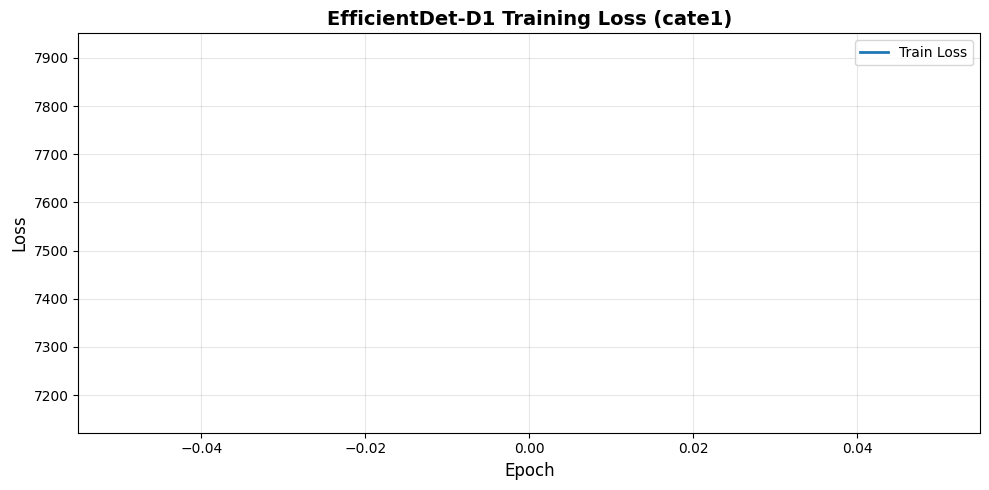


✅ 학습 그래프 저장: c:\Github\class\z-mini_project\fruits\efficientdet\outputs\training_loss_cate1.png


In [16]:
# 8. 학습 결과 시각화
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('EfficientDet-D1 Training Loss (cate1)', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()

plot_path = os.path.join(OUTPUT_DIR, 'training_loss_cate1.png')
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ 학습 그래프 저장: {plot_path}")

TypeError: DetBenchTrain.forward() missing 1 required positional argument: 'target'

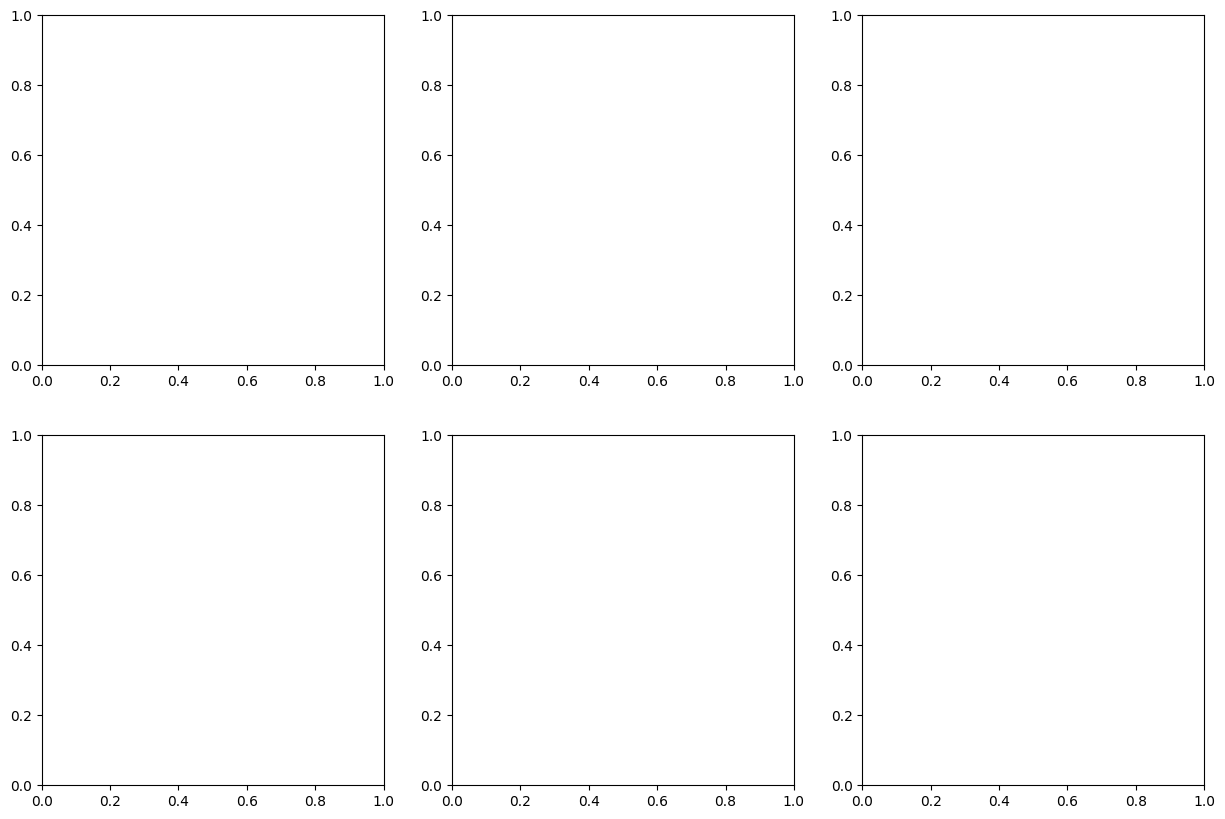

In [17]:
# 9. 추론 및 시각화
def visualize_predictions(model, dataset, device, num_samples=5):
    """예측 결과 시각화"""
    model.eval()
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    class_names = ['사과', '배', '감']
    colors = ['red', 'green', 'blue']
    
    with torch.no_grad():
        for i in range(min(num_samples, len(dataset))):
            img, target = dataset[i]
            
            # 추론
            img_tensor = img.unsqueeze(0).to(device)
            output = model(img_tensor)
            
            # 이미지 denormalize
            img_np = img.cpu().numpy().transpose(1, 2, 0)
            img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            img_np = np.clip(img_np, 0, 1)
            
            axes[i].imshow(img_np)
            axes[i].axis('off')
            axes[i].set_title(f'Sample {i+1}', fontsize=10, fontweight='bold')
            
            # Ground Truth 박스 그리기
            gt_boxes = target['boxes']
            gt_labels = target['labels']
            
            for box, label in zip(gt_boxes, gt_labels):
                x1, y1, x2, y2 = box
                # 정규화된 좌표를 이미지 크기로 변환
                width, height = 512, 512
                x1, x2 = x1 * width / 512, x2 * width / 512
                y1, y2 = y1 * height / 512, y2 * height / 512
                
                rect = plt.Rectangle(
                    (x1, y1), x2 - x1, y2 - y1,
                    fill=False, color=colors[label], linewidth=2
                )
                axes[i].add_patch(rect)
                axes[i].text(
                    x1, y1 - 5,
                    f'{class_names[label]}',
                    color=colors[label],
                    fontsize=9,
                    fontweight='bold',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.7)
                )
    
    plt.tight_layout()
    viz_path = os.path.join(OUTPUT_DIR, 'predictions_cate1.png')
    plt.savefig(viz_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\n✅ 예측 시각화 저장: {viz_path}")

# 시각화 실행
visualize_predictions(model, val_dataset, device, num_samples=6)